In [19]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [26]:
df=pd.read_csv("train.csv",parse_dates=["Date"],index_col=[0])

# Split test and train
ntest = round(len(df)*0.20)  # 20% are test set
df_for_training=df[:-ntest]
df_for_testing=df[-ntest:]

print(df_for_training.shape,'(number of data for training, dim)')
print(df_for_testing.shape,'(number of data for test, dim)')

(4162, 5) (number of data, dim)
(1041, 5) (number of data, dim)


In [27]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.85398707, 0.86281807, 0.85292546, 0.8403402 , 0.82180889],
       [0.85533406, 0.85473269, 0.82623316, 0.8122593 , 0.79289309],
       [0.82155169, 0.84260459, 0.81422168, 0.80701755, 0.78749611],
       ...,
       [0.40689652, 0.40362224, 0.41960282, 0.40436458, 0.7632948 ],
       [0.40517242, 0.39995691, 0.41832161, 0.4075738 , 0.76889077],
       [0.40862067, 0.39974127, 0.41426436, 0.39880189, 0.75359571]])

In [30]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_for_training_scaled,30)
testX,testY=createXY(df_for_testing_scaled,30)

In [32]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

trainX Shape--  (4132, 30, 5)
trainY Shape--  (4132,)
testX Shape--  (1011, 30, 5)
testY Shape--  (1011,)


In [60]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [74]:
def build_model():
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,5)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse',optimizer = 'rmsprop')
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,epochs=100,batch_size=16,optimizer='')
parameters = {'batch_size' : [16,20],  'epochs' : [8,10], 'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

In [ ]:
grid_search = grid_search.fit(trainX,trainY)

In [88]:
print(grid_search.best_params_)
my_model=grid_search.best_estimator_

{'batch_size': 20, 'epochs': 10, 'optimizer': 'adam'}


In [98]:
# Do prediction
prediction=my_model.predict(testX)
prediction

51/51 [==============================] - 1s 14ms/step


array([0.37116963, 0.37494946, 0.3782348 , ..., 0.13947865, 0.14266337,
       0.14603958], dtype=float32)

In [108]:
prediction = prediction.reshape((len(prediction),1))
print("prediction\n", )
print("\nPrediction Shape-",prediction.shape)
prediction.shape

prediction


Prediction Shape- (1011, 1)


(1011, 1)

In [112]:
prediction_copies_array = np.repeat(prediction,5, axis=-1)
prediction_copies_array
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),5)))[:,0]

In [113]:
original_copies_array = np.repeat(testY,5, axis=-1)
original_copies_array.shape
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),5)))[:,0]

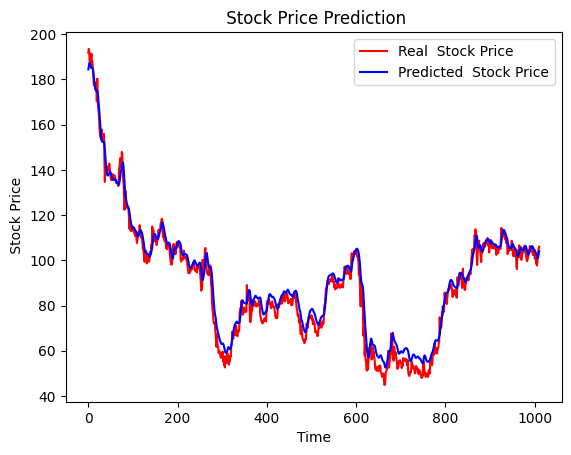

In [115]:
import matplotlib.pyplot as plt
plt.plot(original, color = 'red', label = 'Real  Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [120]:
df_30_days_past=df.iloc[-30:,:]

df_30_days_future=pd.read_csv("test.csv",parse_dates=["Date"],index_col=[0])
df_30_days_future.shape

(30, 4)

In [121]:
df_30_days_future["Open"]=0
df_30_days_future=df_30_days_future[["Open","High","Low","Close","Adj Close"]]
old_scaled_array=scaler.transform(df_30_days_past)
new_scaled_array=scaler.transform(df_30_days_future)
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,0]=np.nan
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)
full_df_scaled_array=full_df.values

In [122]:
all_data=[]
time_step=30
for i in range(time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(full_df_scaled_array[i-time_step:i,0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=my_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

1/1 [==============================] - 0s 23ms/step


In [123]:
all_data

[array([0.14918235], dtype=float32),
 array([0.15065905], dtype=float32),
 array([0.15187167], dtype=float32),
 array([0.15272674], dtype=float32),
 array([0.15312833], dtype=float32),
 array([0.15283516], dtype=float32),
 array([0.15294603], dtype=float32),
 array([0.15303273], dtype=float32),
 array([0.15285206], dtype=float32),
 array([0.15190062], dtype=float32),
 array([0.15058562], dtype=float32),
 array([0.14955215], dtype=float32),
 array([0.14939214], dtype=float32),
 array([0.14941582], dtype=float32),
 array([0.14973459], dtype=float32),
 array([0.15050472], dtype=float32),
 array([0.15067613], dtype=float32),
 array([0.15059705], dtype=float32),
 array([0.15088007], dtype=float32),
 array([0.1523046], dtype=float32),
 array([0.15284178], dtype=float32),
 array([0.15297623], dtype=float32),
 array([0.15293413], dtype=float32),
 array([0.15336417], dtype=float32),
 array([0.1540412], dtype=float32),
 array([0.15444666], dtype=float32),
 array([0.15447134], dtype=float32),
 ar

In [136]:

new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,5, axis=-1)
y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),5)))

In [142]:
y_pred_future_30_days

array([[105.1697  , 108.37752 ,  98.89391 , 104.86757 ,  66.1083  ],
       [105.69677 , 108.904366,  99.425865, 105.3985  ,  66.39593 ],
       [106.12958 , 109.33698 ,  99.86269 , 105.83447 ,  66.63212 ],
       [106.43478 , 109.64205 , 100.170715, 106.14191 ,  66.798676],
       [106.57811 , 109.785324, 100.31538 , 106.28629 ,  66.87689 ],
       [106.47347 , 109.68073 , 100.20977 , 106.18089 ,  66.81979 ],
       [106.51305 , 109.72028 , 100.2497  , 106.22075 ,  66.841385],
       [106.54399 , 109.75121 , 100.280945, 106.25192 ,  66.85828 ],
       [106.47951 , 109.68676 , 100.21586 , 106.186966,  66.82308 ],
       [106.139915, 109.34731 ,  99.873116, 105.84489 ,  66.637764],
       [105.67056 , 108.87817 ,  99.399414, 105.37209 ,  66.38163 ],
       [105.30169 , 108.50945 ,  99.02713 , 105.00052 ,  66.18033 ],
       [105.244576, 108.45236 ,  98.96949 , 104.942986,  66.149155],
       [105.25304 , 108.460815,  98.97802 , 104.95151 ,  66.15377 ],
       [105.366806, 108.57454 ,  9

In [143]:
Close = list(df_30_days_future['Close'])

In [144]:
df_30_days_future

,Open,High,Low,Close,Adj Close
Date,,,,,
2021-09-30,0,107.089996,102.949997,103.029999,102.939865
2021-10-01,0,106.389999,103.669998,105.820000,105.727425
2021-10-04,0,107.080002,104.599998,104.900002,104.808235
2021-10-05,0,106.000000,103.750000,104.900002,104.808235
2021-10-06,0,104.419998,102.059998,104.330002,104.238731
2021-10-07,0,106.529999,104.330002,105.510002,105.417702
2021-10-08,0,106.220001,104.660004,104.720001,104.628387
2021-10-11,0,105.760002,103.970001,104.080002,103.988953
2021-10-12,0,104.040001,101.559998,102.720001,102.630142


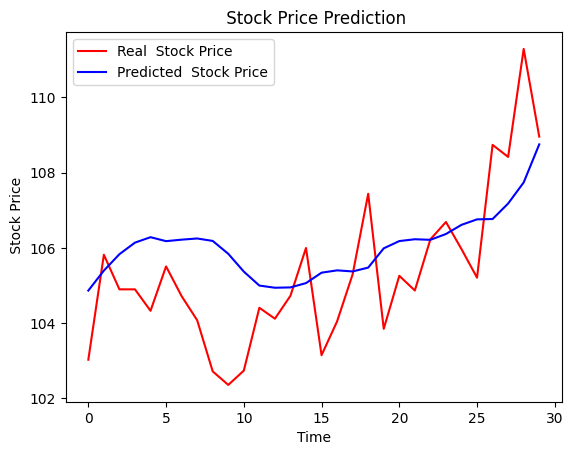

In [145]:
plt.plot(Close, color = 'red', label = 'Real  Stock Price')
plt.plot(y_pred_future_30_days[:,-2], color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()